# IMPORTS

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
import yfinance as yf
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

# GLOSSARY

## TS Decomposition

**Observed**  
shows the result of combining the Trend, Seasonal, and Residuals

**Trend**  
The trend is the slow-moving changes in a time series.  We can think of the trend component as trying to draw a line through most of the data points to show the general direction of a time series.

**Seasonal**
The seasonal component captures the seasonal variation, which is a cycle that occurs over a fixed period of time.
We can see that over the course of a year, or four quarters, the earnings per share start low, increase, and decrease again at the end of the year.
Notice how the y-axis shows negative values. Does this mean that the earnings per share are negative? Clearly, that cannot be, since our dataset strictly has positive values. Therefore, we can say that the seasonal component shows how we deviate from the trend.

**Residuals**
is what cannot be explained by either the trend or the seasonal components. We can think of the residuals as adding the Trend and Seasonal graphs together and comparing the value at each point in time to the Observed graph. Residuals usually correspond to random errors, also termed white noise,They represent information that we cannot model or predict, since it is completely random


<img src="./images/ts-decomposition.png" width="550" />


**MA(q)** Moving Average model

**AR(p)** Autoregressive model

**ARMA(p,q)** Autoregressive moving average model




## Forcasting

Forecasting is predicting the future using historical data and knowledge of future events that might affect our forecasts.

<img src="./images/f-roadmap.png" width="350" />

**Forecast horizon**

Now you can set the horizon of your forecast. In this case, your camping trip is one
month from now, and it will last for one week. Therefore, you have a horizon of one
week, since you are only interested in predicting the minimum temperature during
the camping trip.

## Baseline

The only way to know that a model is good, or performant, is to compare it to a baseline.

## Out-of-sample Forecasting

Make a predicions for a period that was not taken into account when the model was developed

# CH2 Baselines

- TSF should always start with a baseline model that serves as a bechmark for comparision woth more complex models
- Baseline model is a trivial solution to our forecasting
- 

In [2]:
df= pd.read_csv('datasets/jj.csv')

In [3]:
df.head()

,date,data
0,1960-01-01,0.71
1,1960-04-01,0.63
2,1960-07-02,0.85
3,1960-10-01,0.44
4,1961-01-01,0.61


## Decomposition

In [27]:
advanced_decomposition = STL(df['data'], period=4).fit()

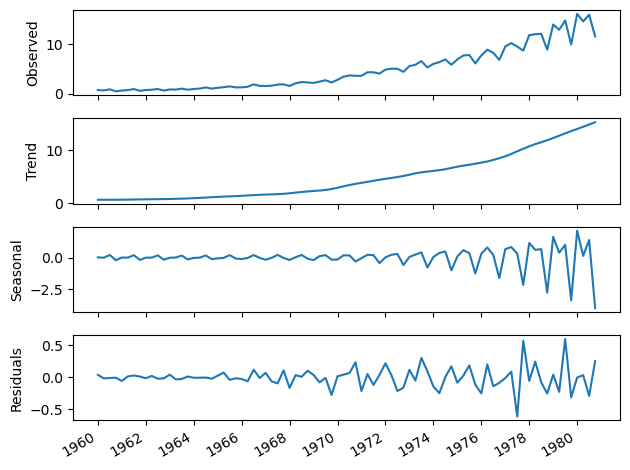

In [28]:
fig, (ax1,ax2,ax3,ax4)= plt.subplots(nrows=4,ncols=1,sharex=True)

ax1.plot(advanced_decomposition.observed)
ax1.set_ylabel('Observed')

ax2.plot(advanced_decomposition.trend)
ax2.set_ylabel('Trend')

ax3.plot(advanced_decomposition.seasonal)
ax3.set_ylabel('Seasonal')

ax4.plot(advanced_decomposition.resid)
ax4.set_ylabel('Residuals')

plt.xticks(np.arange(0,81,8),[1960,1962,1964,1966,1968,1970,1972,1974,1976,1978,1980])

fig.autofmt_xdate()
plt.tight_layout()

## Plot data with train/test split

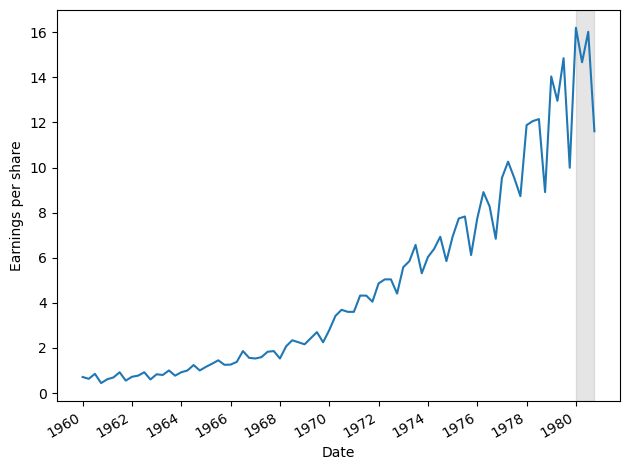

In [13]:
fig, ax= plt.subplots()
ax.plot(df.date, df.data)
ax.set_xlabel('Date')
ax.set_ylabel('Earnings per share')
ax.axvspan(80,83, color='#808080', alpha=.2)
plt.xticks(np.arange(0,81,8),[1960,1962,1964,1966,1968,1970,1972,1974,1976,1978,1980])
fig.autofmt_xdate()
plt.tight_layout()

In [34]:
# Get all except last 4 quarters of 1980
train= df[:-4]

# Get last 4 of 1980 quarters only
test= df[-4:]
print(df.shape, train.shape, test.shape)

(84, 3) (80, 3) (4, 3)


## Historical mean baseline

$
MAPE = \frac{1}{n} \sum_{i=1}^{n} \left| \frac{A_i - F_i}{A_i} \right| \times 100
$

In [37]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [29]:
historical_mean= np.mean(df['data'])
print(f'Historical mean:{historical_mean}')

Historical mean:4.799761892857142


In [39]:
test.loc[: ,'pred_mean'] = historical_mean
mape_hist_mean= mape(test['data'], test['pred_mean'])
print(f'MAPE: {mape_hist_mean}')

MAPE: 66.58773699501253


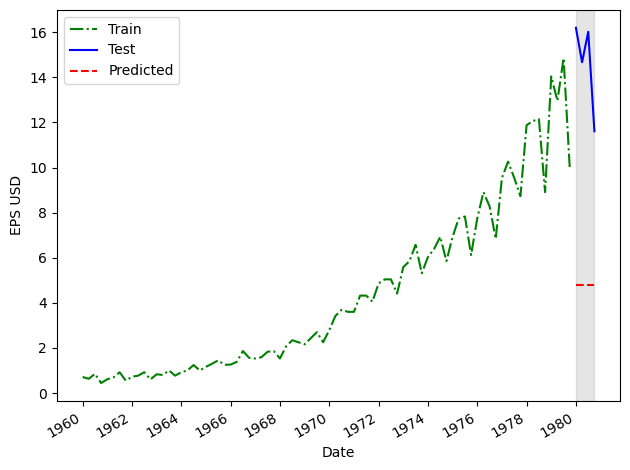

In [41]:
fig, ax=plt.subplots()

ax.plot(train['date'], train['data'], 'g-.', label='Train')
ax.plot(test['date'], test['data'], 'b-', label='Test')
ax.plot(test['date'], test['pred_mean'], 'r--', label='Predicted')

ax.set_xlabel('Date')
ax.set_ylabel('EPS USD')
# Highlight forecast horizon
ax.axvspan(80, 83, color='#808080', alpha=0.2)
ax.legend(loc=2)
plt.xticks(np.arange(0, 85, 8), [1960, 1962, 1964, 1966, 1968, 1970, 1972,1974, 1976, 1978, 1980])

fig.autofmt_xdate()
plt.tight_layout()

**INTERIM CONCLUTION**

MAPE=66% meaning our baseline deviates by 66% frin the observed quarterly EPS

## Last Year Mean

In [44]:
# Last Year mean

last_year_mean= np.mean(train.data[-4:])
print(last_year_mean)

12.96


In [47]:
test.loc[:,'pred_last_yr_mean'] = last_year_mean
mape_last_year_mean= mape(test['data'],test['pred_last_yr_mean'])
print(mape_last_year_mean)

15.5963680725103


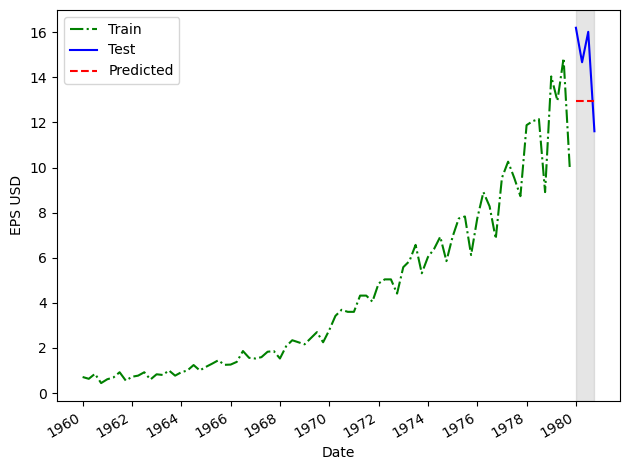

In [49]:
fig, ax=plt.subplots()

ax.plot(train['date'], train['data'], 'g-.', label='Train')
ax.plot(test['date'], test['data'], 'b-', label='Test')
ax.plot(test['date'], test['pred_last_yr_mean'], 'r--', label='Predicted')

ax.set_xlabel('Date')
ax.set_ylabel('EPS USD')
# Highlight forecast horizon
ax.axvspan(80, 83, color='#808080', alpha=0.2)
ax.legend(loc=2)
plt.xticks(np.arange(0, 85, 8), [1960, 1962, 1964, 1966, 1968, 1970, 1972,1974, 1976, 1978, 1980])

fig.autofmt_xdate()
plt.tight_layout()

## Prdicting using the last known value

In [50]:
last = train.data.iloc[-1]
print(last)

9.99


In [53]:
test.loc[:,'pre_last'] = last
mape_last= mape(test['data'],test['pre_last'])
print(mape_last)

30.457277908606535


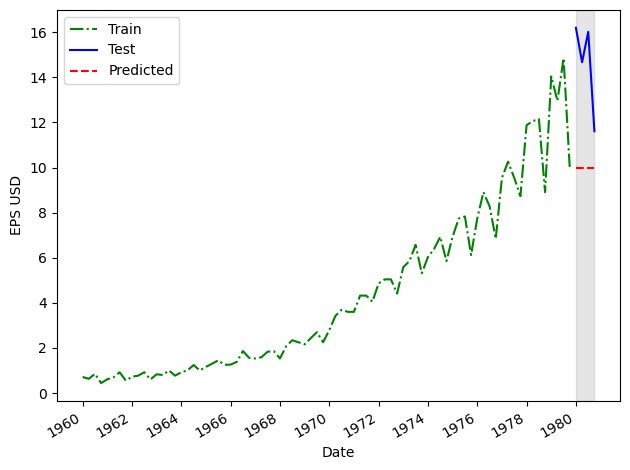

In [54]:
fig, ax=plt.subplots()

ax.plot(train['date'], train['data'], 'g-.', label='Train')
ax.plot(test['date'], test['data'], 'b-', label='Test')
ax.plot(test['date'], test['pre_last'], 'r--', label='Predicted')

ax.set_xlabel('Date')
ax.set_ylabel('EPS USD')
# Highlight forecast horizon
ax.axvspan(80, 83, color='#808080', alpha=0.2)
ax.legend(loc=2)
plt.xticks(np.arange(0, 85, 8), [1960, 1962, 1964, 1966, 1968, 1970, 1972,1974, 1976, 1978, 1980])

fig.autofmt_xdate()
plt.tight_layout()

**INTERIM CONCLUSION**

The result is worster the the last year mean because this logick doesn't taking in account a seasonality, which is exists for this dataset

## Naive seasonal forecast

this forcast takes one last observed cycle and repeats in future

In [55]:
test.loc[:,'pred_last_season'] = train['data'][-4:].values 
mape_naive_seasonal = mape(test['data'],test['pred_last_season'])
print(mape_naive_seasonal)

11.561658552433654


/tmp/ipykernel_473/1335630325.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.loc[:,'pred_last_season'] = train['data'][-4:].values


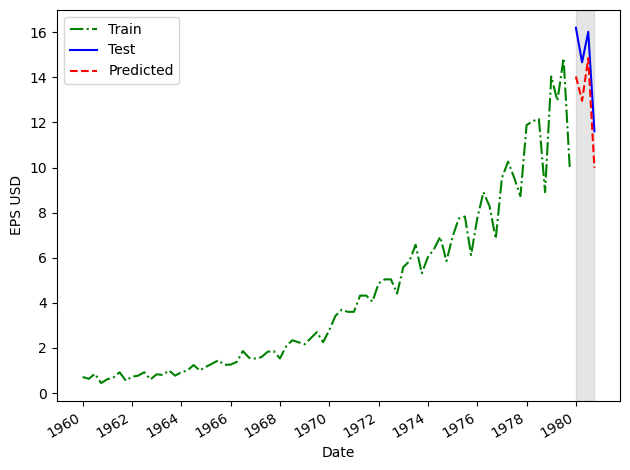

In [56]:
fig, ax=plt.subplots()

ax.plot(train['date'], train['data'], 'g-.', label='Train')
ax.plot(test['date'], test['data'], 'b-', label='Test')
ax.plot(test['date'], test['pred_last_season'], 'r--', label='Predicted')

ax.set_xlabel('Date')
ax.set_ylabel('EPS USD')
# Highlight forecast horizon
ax.axvspan(80, 83, color='#808080', alpha=0.2)
ax.legend(loc=2)
plt.xticks(np.arange(0, 85, 8), [1960, 1962, 1964, 1966, 1968, 1970, 1972,1974, 1976, 1978, 1980])

fig.autofmt_xdate()
plt.tight_layout()

# CH3 Random Walk

**Definition**  
A random walk is a series whose first difference is stationary and uncorrelated. This means that the process moves completely at random.
<img src="./images/random-walk3.png" width="550" />

<img src="./images/random-walk-1.png" width="350" />

A random walk is a process in which there is an equal chance of going up or down by a random number.

In a random walk process, we say that the present value yt is a function of the value
at the previous timestep yt –1, a constant C, and a random number ϵt, also termed white
noise. Here, ϵt is the realization of the standard normal distribution, which has a variance
of 1 and a mean of 0.

$y_t = C + y_t–1 + ϵ_t$

<img src="./images/random-walk2.png" width="550" />

### Simulate random walk

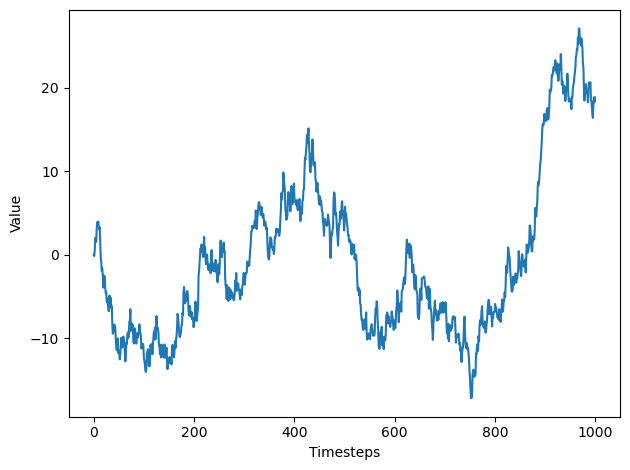

In [57]:
np.random.seed(42)
steps= np.random.standard_normal(1000)
steps[0]=0
random_walk = np.cumsum(steps)
fig, ax = plt.subplots()

ax.plot(random_walk)
ax.set_xlabel('Timesteps')
ax.set_ylabel('Value')

plt.tight_layout()

### Stationary

A stationary time series is one whose statistical properties do not change over time. In
other words, it has a constant mean, variance, and autocorrelation, and these properties
are independent of time.

A transformation is a mathematical manipulation of the data that stabilizes its mean and variance, thus making it stationary.

Differencing is a transformation that calculates the change from one timestep to
another. This transformation is useful for stabilizing the mean.

<img src="./images/transform1.png" width="550" />

#### Stationarity Test | ADF

##### ADF

- H0: Unit root present in TF
  - The time series will be stationary only if the root lies within the unit circle. Therefore, its value must be between –1 and 1. Otherwise
the series is non-stationary.
- H1: not, and therefor TS is stationary
- p < 0.05 - rject H0

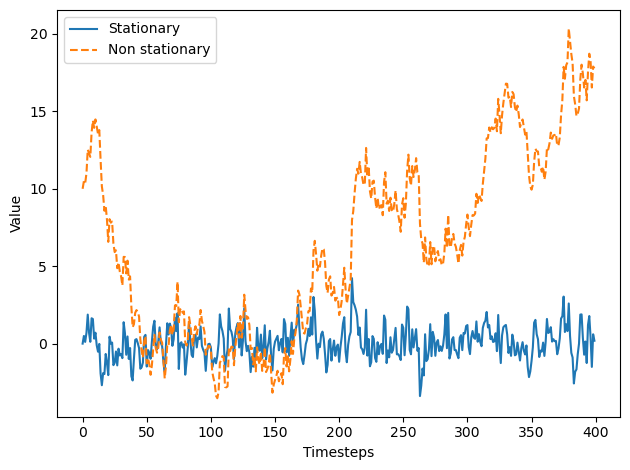

In [58]:
def simulate_process(is_stationary: bool) -> np.array:
    np.random.seed(42)
    process= np.empty(400)

    if is_stationary:
        alpha= 0.5
        process[0]=0
    else:
        alpha=1
        process[0]=10

    for i in range(400):
        if i+1 < 400:
            process[i+1]= alpha * process[i] + np.random.standard_normal()
        else:
            break

    return process

stationary= simulate_process(True)
non_stationary= simulate_process(False)

fig, ax= plt.subplots()
ax.plot(stationary, linestyle='-', label='Stationary')
ax.plot(non_stationary, linestyle='--', label='Non stationary')
ax.set_xlabel('Timesteps')
ax.set_ylabel('Value')
ax.legend(loc=2)

plt.tight_layout()
plt.show()

**INTERIM CONCLUSION**

A stat. series has constant properties over time, meaning  that mean and variance are not function of a time

/home/zai11972/miniconda3/envs/tensrnv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/zai11972/miniconda3/envs/tensrnv/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


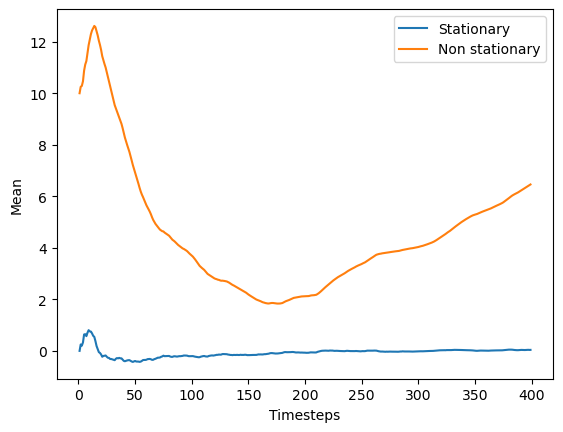

In [59]:
def mean_over_time(process: np.array) -> np.array:
    mean_func= []

    for i in range(len(process)):
        mean_func.append(np.mean(process[:i]))

    return mean_func

stat_mean= mean_over_time(stationary)
non_stat_mean = mean_over_time(non_stationary)

fig, ax=plt.subplots()

ax.plot(stat_mean, label='Stationary')
ax.plot(non_stat_mean, label='Non stationary')
ax.set_xlabel('Timesteps')
ax.set_ylabel('Mean')
ax.legend(loc=1)

plt.show()

/home/zai11972/miniconda3/envs/tensrnv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/zai11972/miniconda3/envs/tensrnv/lib/python3.11/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/zai11972/miniconda3/envs/tensrnv/lib/python3.11/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


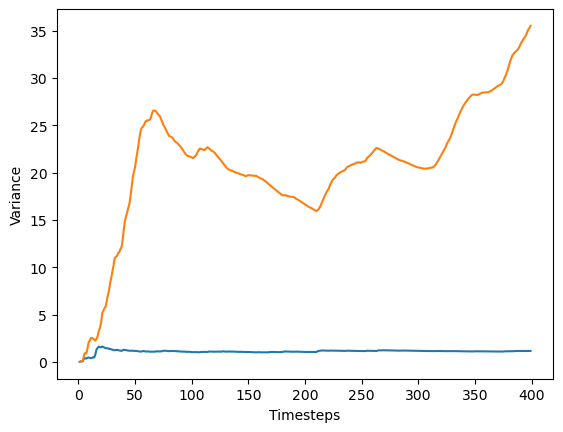

In [60]:
def var_overtime(process: np.array) -> np.array:
    var_func= []

    for i in range(len(process)):
        var_func.append(np.var(process[:i]))

    return var_func

stat_var= var_overtime(stationary)
non_stat_var= var_overtime(non_stationary)

fig, ax= plt.subplots()

ax.plot(stat_var, label='Stationary')
ax.plot(non_stat_var, label='Non stationary')
ax.set_xlabel('Timesteps')
ax.set_ylabel('Variance')

plt.show()

**INTERIM CONCLUSION**

Once stationary determined we need to determine whethe there is autocorelation or not, to make sure that this is not a random walk whose first difference is stationory and uncorrelated. ADF doesn't show autocorelation

#### Autocorelation | ACF

Autocorelation measures the linear relationship between lagged values of a TS. Another words it measures the corelation of the time series with it self

Lag: the number of timesteps separating by 2 values

### ALL TOGETHER

In [62]:
adf_result=adfuller(random_walk)
print(f'ADF Statistics: {adf_result[0]}')
print(f'p-val: {adf_result[1]}')

ADF Statistics: -0.965952487691875
p-val: 0.7654789696692581


**INTERIM CONCLUSION**

ADF stat is not a large negative val, also p-value is greater the 5% therefor we can not regect H0 thus our TS is not stationary

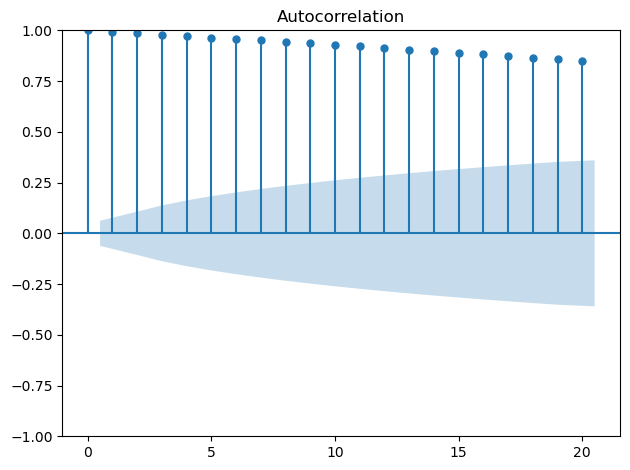

In [66]:
plot_acf(random_walk, lags=20)
plt.tight_layout()

**INTERIM CONCLUSION**

We observe that autocor coef. slowly decreases as the lag increases which is a clear indicator that our random walk is not stationary process.
The shaded area represent confidence interval(доверительный интервал). If the point is in shaded area then it is not signifcatly different from 0(mean random), otherwise the autocor is significant(meaning correlation is present).

We obser stron corelation thus transformation is required in order to retreive usefull information from the ACF

#### Transformation

Since we don't observe seasonal patterns in trend wewill apply a first-order differencing

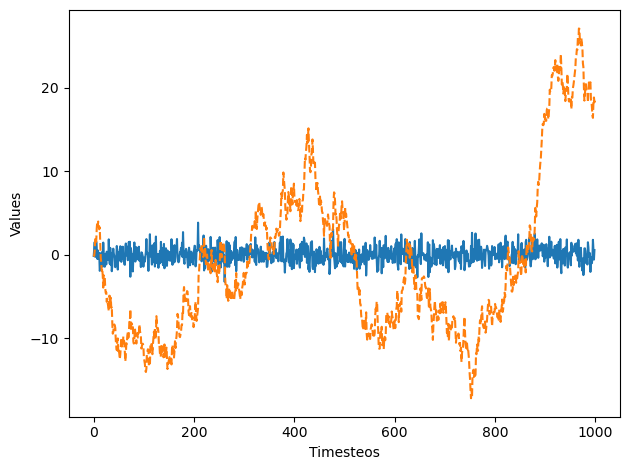

In [68]:
diff_random_walk= np.diff(random_walk,n=1)

fig, ax= plt.subplots()
ax.plot(diff_random_walk, label='Differencing')
ax.plot(random_walk,linestyle='--', label='Original')
ax.set_xlabel('Timesteos')
ax.set_ylabel('Values')
plt.tight_layout()
plt.show()

ADF result: -31.7893108575606, p-val:0.0


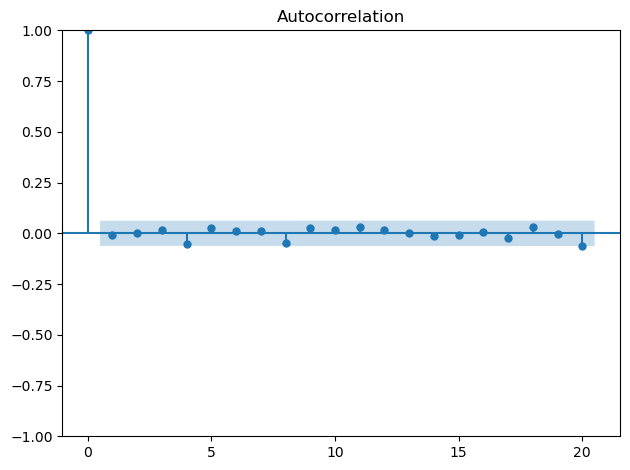

In [72]:
adf_result= adfuller(diff_random_walk)
print(f'ADF result: {adf_result[0]}, p-val:{adf_result[1]}')

plot_acf(diff_random_walk, lags=20)
plt.tight_layout()

**INTERIM CONCLUSION**

The Timeseries has been successfully transformed. Non stationarity removed, thus H0 can be rejected, as process doesn't have a unit root.
There is nomore significant autocorrelation exists after lag 0, this means a stationary process is compleetly random and can be described as a white noise

Thus we has demostrated that our timeseries after transformation applied is a random walk, as series become a stationary  and uncorrelated after a first-order transform has been applied

### PLAY WITH GOOGL

In [74]:
# conda install -c forge yfinance
ticker='GOOGL'
start_date= '2020-04-27'
end_date='2021-04-27'

googl_finslice_df= yf.download(ticker,start_date,end_date) 
googl_finslice_df.head()

[*********************100%***********************]  1 of 1 completed


Price,Adj Close,Close,High,Low,Open,Volume
Ticker,GOOGL,GOOGL,GOOGL,GOOGL,GOOGL,GOOGL
Date,,,,,,
2020-04-27,63.386044,63.542999,64.705002,63.252998,64.599998,44186000
2020-04-28,61.477272,61.629501,64.237999,61.519001,64.160004,80700000
2020-04-29,66.943237,67.109001,68.007500,66.336502,67.250000,108358000
2020-04-30,67.168678,67.334999,67.500000,66.074997,66.568001,55842000
2020-05-01,65.703308,65.865997,67.571503,65.483002,66.204498,48872000


**DATA STRUCTURE**

Index: Dates (trading days).

Columns:
- `Open`: Opening price of the stock.
- `High`: Highest price during the day.
- `Low`: Lowest price during the day.
- `Close`: Closing price of the stock.
- `Adj Close`: Adjusted closing price (accounts for splits, dividends, etc.).
- `Volume`: Number of shares traded.

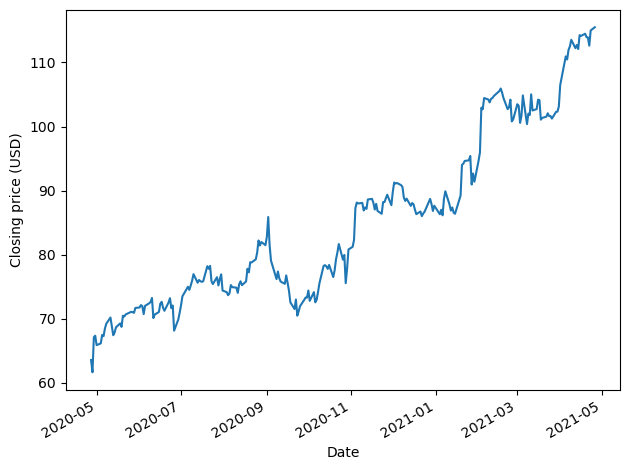

In [92]:
fig, ax= plt.subplots()

ax.plot(googl_finslice_df.index, googl_finslice_df['Close'])
ax.set_xlabel('Date')
ax.set_ylabel('Closing price (USD)')

fig.autofmt_xdate()
plt.tight_layout()
plt.show()

**INTERIM CONCLUSION**

We observer that the trend and closing price is increasing therefore the process in non stationary. This further should be confirmed by ADF test

#### Transformation

In [105]:
ADF_GOOGL_res= adfuller(googl_finslice_df['Close'])

print(f'ADF stat:{ADF_GOOGL_res[0]}, p-val:{ADF_GOOGL_res[1]}')

ADF stat:0.31837760731397025, p-val:0.978172106366102


In [106]:
close_prices = googl_finslice_df[('Close', 'GOOGL')]
diff_close = np.diff(close_prices, n=1)

In [107]:
diff_close[:5]

array([-1.91349792,  5.47949982,  0.22599792, -1.46900177,  0.27899933])

In [108]:
ADF_GOOGL_res=adfuller(diff_close)

print(f'ADF stat:{ADF_GOOGL_res[0]}, p-val:{ADF_GOOGL_res[1]}')

ADF stat:-5.263208793484012, p-val:6.522976108151055e-06


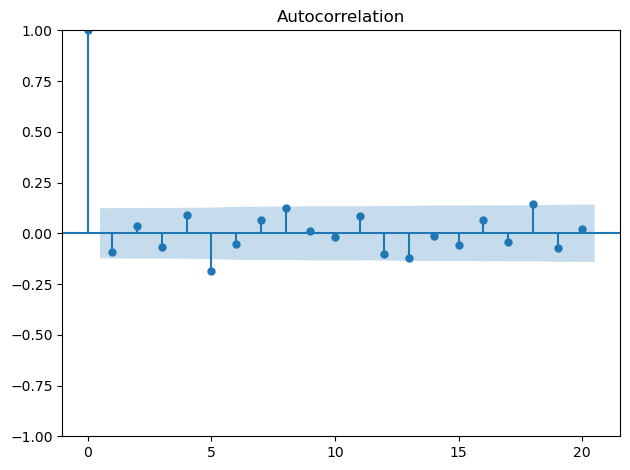

In [109]:
plot_acf(diff_close,lags=20)
plt.tight_layout()


**INTERIM CONCLUSION**

We do not see any significant correlations except lag 5 and 18, but because we do not have any consecuteive significant coefs we can safelly assume that these coefs are not signif9icant. 

Therefore we can conclude that that closing prices can be approximated by a random walk process

#### Forcast

Important to know that predict random walk is impossible. It is same as we woulfd try to predict random values. Therefore we can use naive forcasting methods or baselines.

Since the values changed randomly no stat models can be applied. 
We can only reasonably predict historical mean or last value

**Forcast on long horizon**

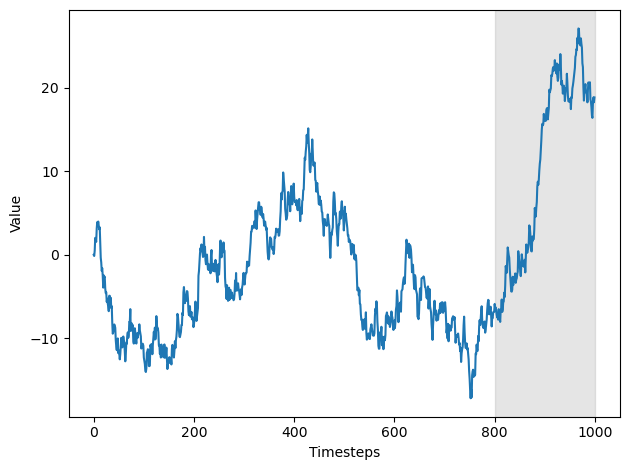

In [111]:
df= pd.DataFrame({'value': random_walk})

train_df= df[:800]
test_df=df[800:]

fig, ax= plt.subplots()

ax.plot(random_walk)
ax.set_xlabel('Timesteps')
ax.set_ylabel('Value')
ax.axvspan(800,1000, color='#808080', alpha=.2)
plt.tight_layout()
plt.show()

**MEAN FORCAST**

In [113]:
mean= np.mean(train_df.value)

test_df.loc[:,'pred_mean']=mean
test_df.head()

/tmp/ipykernel_473/3324397271.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df.loc[:,'pred_mean']=mean


,value,pred_mean
800,-5.876664,-3.677206
801,-6.392708,-3.677206
802,-6.296588,-3.677206
803,-6.758863,-3.677206
804,-7.193359,-3.677206


**LAST VALUE FORECAST**

In [114]:
last_val= train_df.iloc[-1].value
test_df.loc[:,'pred_last']= last_val
test_df.head()

/tmp/ipykernel_473/1572902736.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df.loc[:,'pred_last']= last_val


,value,pred_mean,pred_last
800,-5.876664,-3.677206,-6.814947
801,-6.392708,-3.677206,-6.814947
802,-6.296588,-3.677206,-6.814947
803,-6.758863,-3.677206,-6.814947
804,-7.193359,-3.677206,-6.814947


**DRIFT FORECAST**

$
    \text{drift}= \frac{\Delta{y}}{\Delta{x}} 
$

In [116]:
delta_x= 800 - 1
delta_y= last_val - 0
drift = delta_y / delta_x

In [119]:
x_vals= np.arange(801,1001, 1)
pred_drift= drift * x_vals
test_df.loc[:, 'pred_drift']= pred_drift
test_df.head()

,value,pred_mean,pred_last,pred_drift
800,-5.876664,-3.677206,-6.814947,-6.832006
801,-6.392708,-3.677206,-6.814947,-6.840536
802,-6.296588,-3.677206,-6.814947,-6.849065
803,-6.758863,-3.677206,-6.814947,-6.857594
804,-7.193359,-3.677206,-6.814947,-6.866124


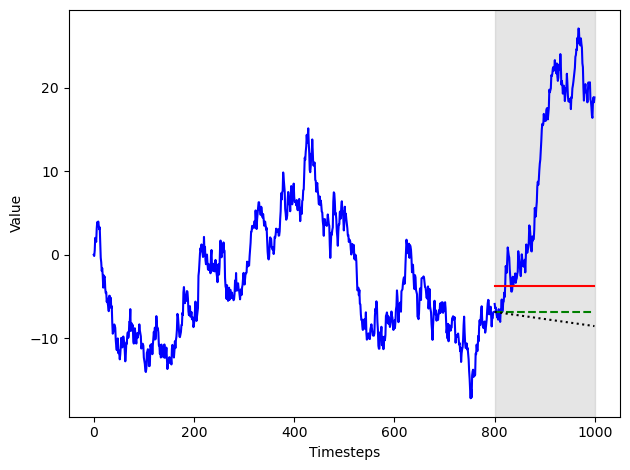

In [121]:
fig,ax= plt.subplots()

ax.plot(train_df.value, 'b-')
ax.plot(test_df.value, 'b-')
ax.plot(test_df.pred_mean, 'r-')
ax.plot(test_df.pred_last, 'g--')
ax.plot(test_df.pred_drift, 'k:')

ax.axvspan(800,1000, color='#808080', alpha=.2)
ax.set_xlabel('Timesteps')
ax.set_ylabel('Value')
plt.tight_layout()
plt.show()

**Calculate Loss**

In [123]:
mse_mean= mean_squared_error(test_df.value, test_df.pred_mean)
mse_last= mean_squared_error(test_df.value, test_df.pred_last)
mse_drift= mean_squared_error(test_df.value, test_df.pred_drift)

print(f'MSE mean:{mse_mean}, MSE last:{mse_last}, MSE drift:{mse_drift}')

MSE mean:326.50277395297474, MSE last:425.1726033055617, MSE drift:466.2172769077409


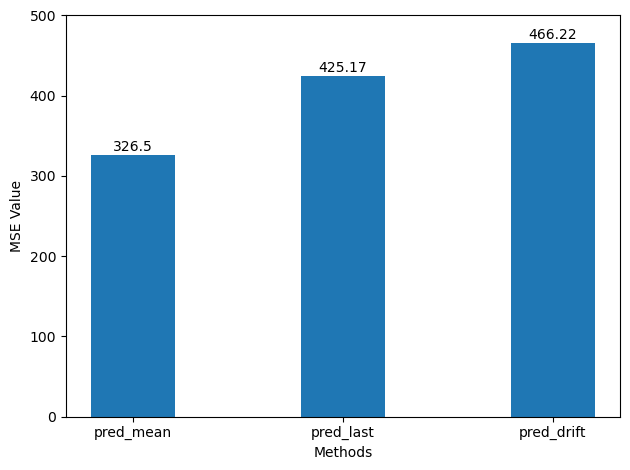

In [124]:
x= ['pred_mean', 'pred_last', 'pred_drift']
y= [mse_mean, mse_last, mse_drift]

fig, ax= plt.subplots()
ax.bar(x,y, width=.4)
ax.set_xlabel('Methods')
ax.set_ylabel('MSE Value')
ax.set_ylim(0,500)

for i, v in enumerate(y):
    plt.text(x=i,y=v+5,s=str(round(v,2)),ha='center')

plt.tight_layout()
plt.show()

**INTERIM CONCLUSION**

The best performance has been demonstrated by the historical mean, yet the value over 300 as our simulated random walk value does not exceed 30. Therefore forecasring a random walk on a long horizon doesn't make sence

**Forcasting next timestep**

<img src="./images/forecast-next-timestep.png" width="550" />

Forcasting the next timestep of a random walk is the only reasonable sitiation we can go.

Future val of random walk is the past val + white noise

In [126]:
# forecast next timestep i.e. periods=1
df_shift= df.shift(periods=1)
df_shift.head()

,value
0,NaN
1,0.000000
2,-0.138264
3,0.509424
4,2.032454


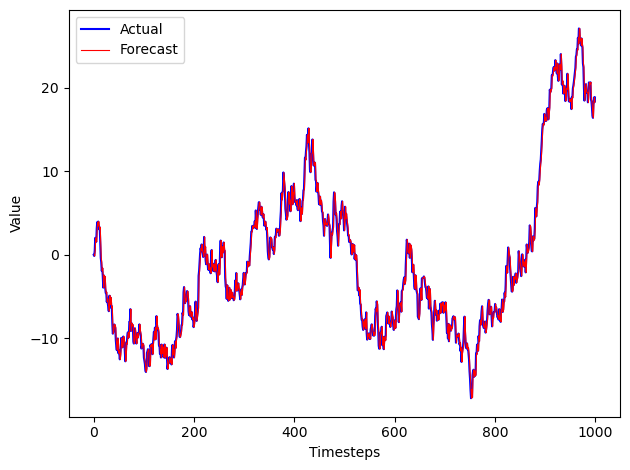

In [134]:
fig, ax= plt.subplots()

ax.plot(df,'b-', label='Actual')
ax.plot(df_shift,'r-', linewidth=.8, label='Forecast')
ax.legend(loc=2)
ax.set_xlabel('Timesteps')
ax.set_ylabel('Value')

plt.tight_layout()
plt.show()

In [ ]:
test

In [136]:
mse_one_step= mean_squared_error(test_df['value'], df_shift[800:])

mse_one_step

0.9256876651440581

**Zoom In**

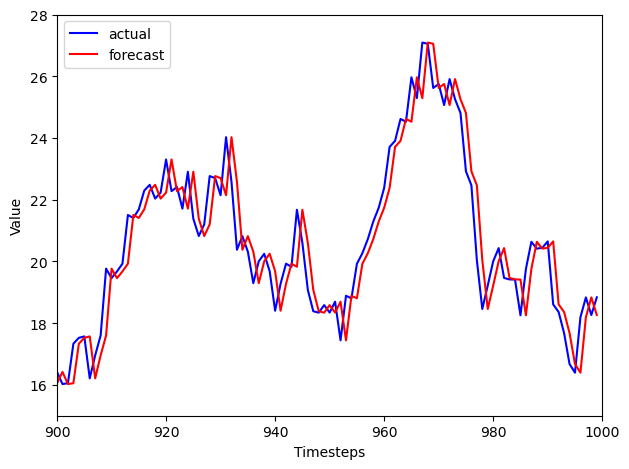

In [138]:
fig, ax= plt.subplots()

ax.plot(df,'b-',label='actual')
ax.plot(df_shift,'r-', label='forecast')
ax.legend(loc=2)

ax.set_xlim(900,1000)
ax.set_ylim(15,28)
ax.set_xlabel('Timesteps')
ax.set_ylabel('Value')

plt.tight_layout()
plt.show()

# CH4 Modeling MA(q) (Moving Average)

In a MA process the current value depends linearly on the mean of the series, the current error term and past error terms

**MA(q) model** 
- states that the current value is linearly dependent on the current and past error terms. The error terms are assumed to be mutualy independednt and normaly distributed just like white noise.
- q: is the order
- the modele express the present value as a linear combination of the:
  - $\mu$ : mean of the seris
  - $\epsilon_t$ : the present error
  - $\epsilon_t-_q$ : past error term
  - $\theta_q$ : magnitude of the impact of past errors on the present value

MA(q) $y_t = \mu + \epsilon_t + \theta_1 \epsilon_{t-1} + \theta_2\epsilon_{t-2} + \cdots +\theta_q\epsilon_{t-q}$

<img src="./images/MA-1.png" width="550" />


4-1 Figure shows long-term trend with Peaks and troughts. It is not a stationary process since we can not observe a trend overtime, furthermore there is no apparent cyclical pattern in the data so we can rule out any seasonal effects for now. 

### 1. Identify the order

In [2]:
df= pd.read_csv('./datasets/widget_sales.csv')
df.head()

,widget_sales
0,50.496714
1,50.805493
2,51.477758
3,53.542228
4,54.873108


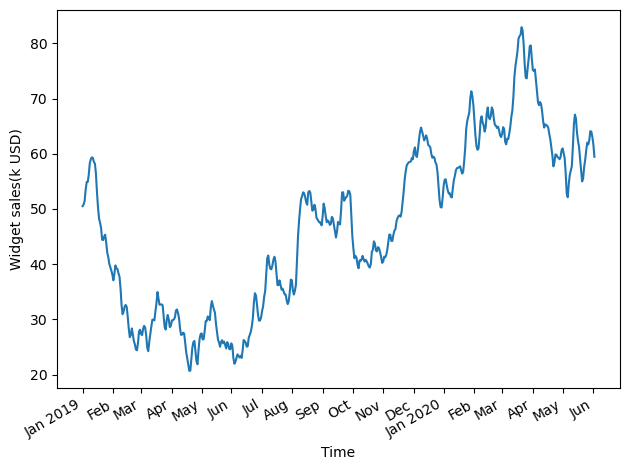

In [5]:
fig, ax= plt.subplots()

ax.plot(df['widget_sales'])
ax.set_xlabel('Time')
ax.set_ylabel('Widget sales(k USD)')
plt.xticks(
    [0, 30, 57, 87, 116, 145, 175, 204, 234, 264, 293, 323, 352, 382, 409, 439, 468, 498], 
    ['Jan 2019', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Jan 2020', 'Feb', 'Mar', 'Apr', 'May', 'Jun'])

# Tilt the labels ib the x-axis ticks so that they display nicely
fig.autofmt_xdate()
# Remove extra whitespaces around the figure
plt.tight_layout()
plt.show()

#### 1.1 Test for stationarity

On the figure abouve it is obvious that there is no stattionarity as there is no observable trend, hovewer we must make sure

In [7]:
ADF_result= adfuller(df['widget_sales'])

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -1.5121662069358996
p-value: 0.5274845352272631


**INTERIM CONCLUSION**

The ADF stat is not large negative number, and p-val is above 0.05, therefore our timeline is not stationary and we must apply transformations to make it stationary

#### 1.2. Transformations

In this example we will stabilize the trand by applying firs-order diff

In [8]:
# n=1 because it is first order diff
widget_sales_diff= np.diff(df['widget_sales'], n=1)

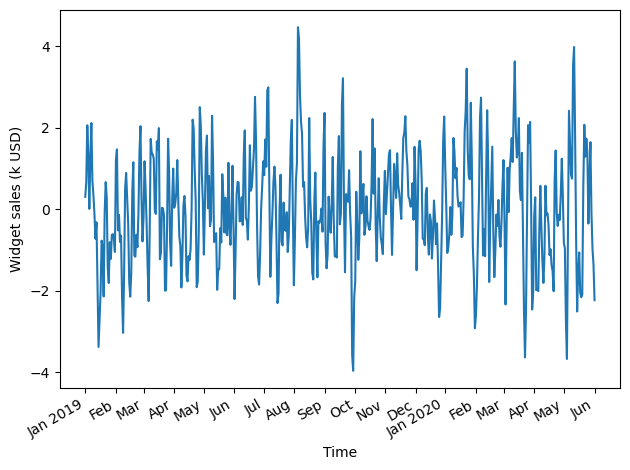

In [9]:
fig, ax= plt.subplots()
ax.plot(widget_sales_diff)
ax.set_xlabel('Time')
ax.set_ylabel('Widget sales (k USD)')
plt.xticks(
    [0, 30, 57, 87, 116, 145, 175, 204, 234, 264, 293, 323, 352, 382, 409, 439, 468, 498], 
    ['Jan 2019', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Jan 2020', 'Feb', 'Mar', 'Apr', 'May', 'Jun'])
fig.autofmt_xdate()
plt.tight_layout()
plt.show()


In [10]:
ADF_result= adfuller(widget_sales_diff)

print(f'ADF Statistics: {ADF_result[0]}')
print(f'p-val: {ADF_result[1]}')

ADF Statistics: -10.576657780341957
p-val: 7.076922818587346e-19


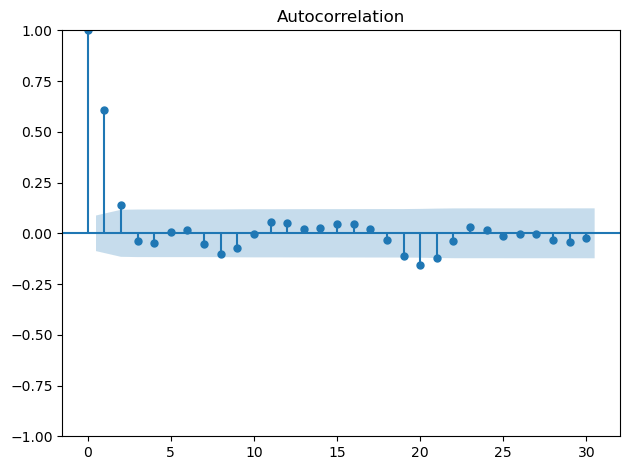

In [11]:
plot_acf(widget_sales_diff, lags=30)
plt.tight_layout()

**INTERIM CONCLUSION**

The ADF stat is relitevly large negative value, p-val is less the 0.05, also we can see on figure that long-term trend has been removed as all values are hovering around 0. On a ACF plot we observe significant coefs up untill 2, anf then they are abruptly become insignificant as they a re remain in shaded area. All above means that we have a stationary moving average model MA(2)(i.e the order of MA is 2) to forecast out stationary time series.

### 2. Forcast MA 

When using an MA(q) model, forecasting beyond q steps into the future will simply
return the mean, because there are no error terms to estimate beyond q steps. Thus we
should use rolling forecasts to predict up to q steps at a time in order avoid predicting
only the mean of the series.

In [12]:
# Split data on train and test
df_diff= pd.DataFrame({'widget_sales_diff': widget_sales_diff})

train_df= df_diff[:int(.9 * len(df_diff))] # 90% to train
test_df= df_diff[int(.9 * len(df_diff)):] # 10% to test

# Note that original dataset has 500 datapoints but our diff has onluy 499 since we have diff once
print(f'train_df: {train_df.shape}')
print(f'test_df: {test_df.shape}')

train_df: (449, 1)
test_df: (50, 1)


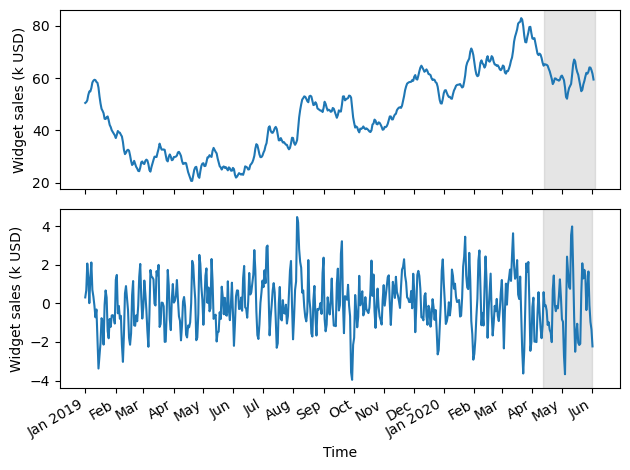

In [14]:
# Visualuze the forecasting period for the difference and orogonal series

# Make 2 subplots insude same figure
fig, (ax1, ax2)= plt.subplots(nrows=2, ncols=1, sharex=True)

ax1.plot(df['widget_sales'])
ax1.set_xlabel('Time')
ax1.set_ylabel('Widget sales (k USD)')
ax1.axvspan(450,500, color='#808080', alpha=.2)

ax2.plot(widget_sales_diff)
ax2.set_xlabel('Time')
ax2.set_ylabel('Widget sales (k USD)')
ax2.axvspan(449, 498, color='#808080', alpha=.2)

plt.xticks(
    [0, 30, 57, 87, 116, 145, 175, 204, 234, 264, 293, 323, 352, 382, 409, 439, 468, 498], 
    ['Jan 2019', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Jan 2020', 'Feb', 'Mar', 'Apr', 'May', 'Jun'])
fig.autofmt_xdate()
plt.tight_layout()
plt.show()

In [16]:
# A function for rolling forecast on a horizon

import numpy as np
from pandas import DataFrame
from statsmodels.tsa.statespace.sarimax import SARIMAX
from scipy.stats import t  # Assuming you'll need it later for confidence intervals

def rolling_forecast(df: DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:
    """
    Perform rolling forecasts on a time series DataFrame using different methods:
    - Mean of the observed data
    - Last observed value
    - Moving Average (MA) model of order (0, 0, 2)

    Parameters
    ----------
    df : DataFrame
        The time series data as a Pandas DataFrame with a single column of numeric values.
    train_len : int
        The initial number of data points used to fit the model.
    horizon : int
        The number of future data points to predict (test set length).
    window : int
        The number of timesteps predicted in each iteration (forecast window size).
    method : str
        The forecasting method to use:
        - 'mean': Forecast using the mean of the training data.
        - 'last': Forecast using the last observed value.
        - 'MA': Forecast using a Moving Average (MA) model.

    Returns
    -------
    list
        A list of predicted values for the specified horizon.

    Raises
    ------
    ValueError
        If an unsupported method is provided.
    """
    total_len = train_len + horizon

    if method == 'mean':
        pred_mean = []
        for i in range(train_len, total_len, window):
            # Calculate mean of data up to the current point
            mean = np.mean(df[:i].values)
            # Extend the mean prediction for the length of the window
            pred_mean.extend(mean for _ in range(window))
        return pred_mean

    elif method == 'last':
        pred_last_value = []
        for i in range(train_len, total_len, window):
            # Take the last observed value as the prediction
            last_value = df[:i].iloc[-1].values[0]
            # Extend the last value prediction for the length of the window
            pred_last_value.extend(last_value for _ in range(window))
        return pred_last_value

    elif method == 'MA':
        pred_MA = []
        for i in range(train_len, total_len, window):
            # Fit a Moving Average model of order (0, 0, 2)
            model = SARIMAX(df[:i], order=(0, 0, 2))
            res = model.fit(disp=False)
            # Get predictions for the next `window` steps
            predictions = res.get_prediction(start=i, end=i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            # Extend the out-of-sample predictions for the window size
            pred_MA.extend(oos_pred)
        return pred_MA

    else:
        raise ValueError(f"Unsupported forecasting method: {method}")

In [18]:
%%time
TRAIN_LEN= len(train_df)
HORIZON= len(test_df)
WINDOW=2

pred_df= test_df.copy()

pred_df['pred_mean']= rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'mean')
pred_df['pred_last_val']= rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_df['pred_MA']= rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'MA')

pred_df.head()

CPU times: user 1.48 s, sys: 9.12 ms, total: 1.49 s
Wall time: 495 ms


,widget_sales_diff,pred_mean,pred_last_val,pred_MA
449,-1.170131,0.034319,-1.803658,-1.078833
450,0.580967,0.034319,-1.803658,-0.273309
451,-0.144902,0.032861,0.580967,0.781223
452,-0.096564,0.032861,0.580967,0.234969
453,-0.372334,0.032183,-0.096564,0.168994


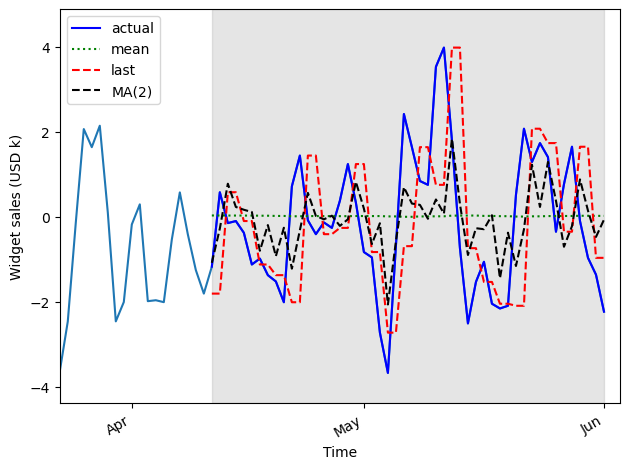

In [19]:
fig, ax= plt.subplots()

ax.plot(df_diff['widget_sales_diff'])
ax.plot(pred_df['widget_sales_diff'], 'b-', label='actual')
ax.plot(pred_df['pred_mean'], 'g:', label='mean')
ax.plot(pred_df['pred_last_val'], 'r--', label='last')
ax.plot(pred_df['pred_MA'], 'k--', label='MA(2)')

ax.legend(loc=2)

ax.set_xlabel('Time')
ax.set_ylabel('Widget sales (USD k)')

ax.axvspan(449, 498, color='#808080', alpha=.2)
ax.set_xlim(430, 500)

plt.xticks(
    [439, 468, 498], 
    ['Apr', 'May', 'Jun'])

fig.autofmt_xdate()
plt.tight_layout()
plt.show()

**INTERIM CONCLUSION**

- prediction coming from the historical mean, shown as a dotted line, is almost a straight line. This is expected as the process is stationary, so the historical mean should be stable over time

### 3. Measure models performance

In [23]:
mse_mean= mean_squared_error(pred_df['widget_sales_diff'], pred_df['pred_mean'])
mse_last= mean_squared_error(pred_df['widget_sales_diff'], pred_df['pred_last_val'])
mse_MA= mean_squared_error(pred_df['widget_sales_diff'], pred_df['pred_MA'])

print(f'MSE mean:{mse_mean}, MSE last:{mse_last}, MSE MA(2):{mse_MA}')

MSE mean:2.5606299456880537, MSE last:3.2494260812249225, MSE MA(2):1.9481714497788523


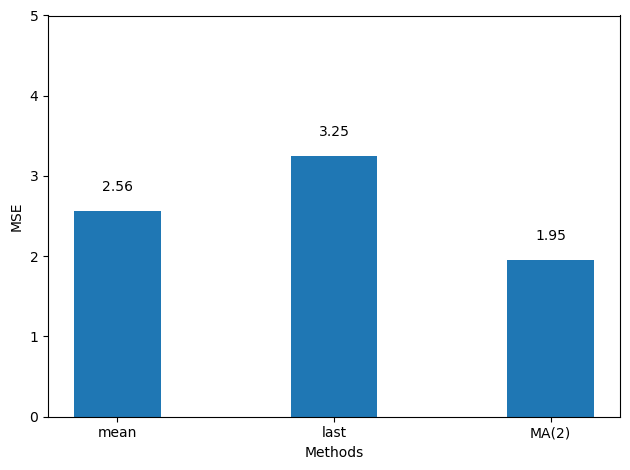

In [26]:
x= ['mean', 'last', 'MA(2)']
y= [mse_mean, mse_last, mse_MA]

fig, ax= plt.subplots()
ax.bar(x, y, width=.4)
ax.set_xlabel('Methods')
ax.set_ylabel('MSE')
ax.set_ylim(0,5)

for i, v in enumerate(y):
    plt.text(x=i, y=v + .25, s=str(round(v,2)), ha='center')

plt.tight_layout()
plt.show()


**INTERIM CONCLUSION**

MA(2) model is the best-performing forecasting method, since its MSE is the lowest of the three methods. This is expected,
because we previously identified a second-order moving average process for the differenced
volume of widget sales, thus resulting in a smaller MSE compared to the
naive forecasting methods. 

### 4. Inverse transform

<img src="./images/fo-diff.png" width="500"/>

- we need to inversetransform our predictions to bring them back to the original scale of the untransformed dataset.

- In order to reverse our first-order difference, we need to add an initial value y0 to the first differenced value y'1

- to obtain our predictions in the original scale of our dataset, we need to use the first value of the test as our initial value. Then we can perform a cumulative sum to obtain a series of 50 predictions in the original scale of the dataset. We will assign these predictions to the pred_widget_sales column.

In [28]:
# init empty column to hold pred
df['pred_widget_sales']= pd.Series()

# Inverse transform the predictions to bring them back to the original scale of dataset
df['pred_widget_sales'][450:]= df['widget_sales'].iloc[450] + pred_df['pred_MA'].cumsum()

/tmp/ipykernel_24424/2104859232.py:5: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['pred_widget_sales'][450:]= df['widget_sales'].iloc[450] + pred_df['pred_MA'].cumsum()
/tmp/ipykernel_24424/2104859232.py:5: SettingWithCopyWarning: 
A va

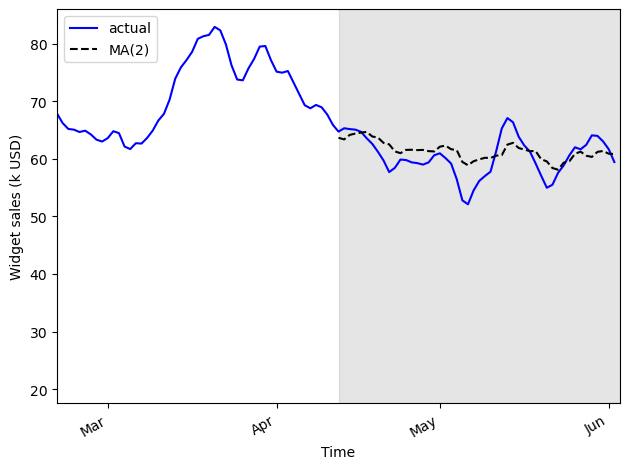

In [32]:
fig, ax= plt.subplots()

ax.plot(df['widget_sales'], 'b-', label='actual')
ax.plot(df['pred_widget_sales'], 'k--', label='MA(2)')

ax.legend(loc=2)
ax.set_xlabel('Time')
ax.set_ylabel('Widget sales (k USD)')

ax.axvspan(450,500, color='#808080', alpha=.2)
ax.set_xlim(400,500)
plt.xticks(
[409, 439, 468, 498],
['Mar', 'Apr', 'May', 'Jun'])

fig.autofmt_xdate()
plt.tight_layout()
plt.show()

### 5. Report Errors

In [35]:
mae_MA_undiff= mean_absolute_error(df['widget_sales'].iloc[450:], df['pred_widget_sales'].iloc[450:])

print(f'MAE MA(2) undiff: {mae_MA_undiff}')

MAE MA(2) undiff: 2.3244709245355


**INTERIM CONCLUSION**

MAE of 2.32. Therefore, our predictions are, on average, off by $2,320, either above or below the actual value. Notice that our data has units of thousands of dollars, so we multiply the MAE by 1,000 to express the average absolute difference.